In [1]:
import pandas as pd
import numpy as np
from Higgs.tools.ImplementationUtils import (
    implementChannelLimit,
    implementChannelWidthLimit,
    fromHB5Table1,
    readHEPDataCsv,
)
from Higgs import Predictions
from Higgs import predictions as HP
from Higgs import bounds as HB
from Higgs.tools.LimitValidation import validateChannelLimit, validateChannelWidthLimit
import os, sys
import matplotlib.pyplot as plt
import pwlf
from scipy.interpolate import interp1d

sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
import MassResolutions as resolution


# ATLAS 13TeV LHC

## `H>gamgam` width-dep fiducial cxn limit with efficiencies [2102.13405](https://arxiv.org/abs/2102.13405)

The efficiencies are only given for the NWA, we approximately assume that they do not change for finite width. The width dependent limit only goes down to 400GeV, so there is a separate implementation of the narrow width limit for lower masses.

**If you rerun this in the future check if they fixed the 1/10 instead of % for the width in HEPData**

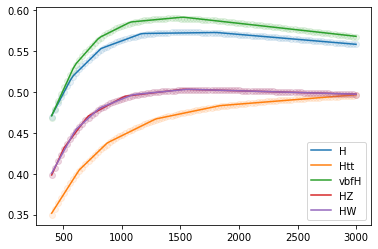

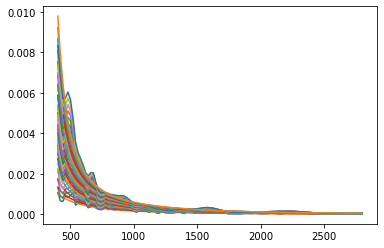

Looks good. Saving this to comb_LHC13_ATLAS_139.json


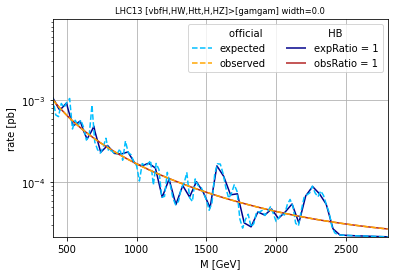

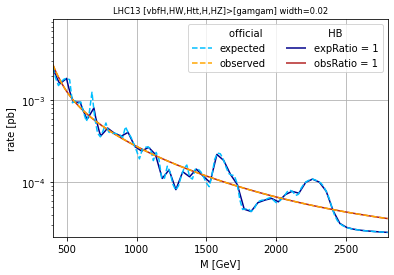

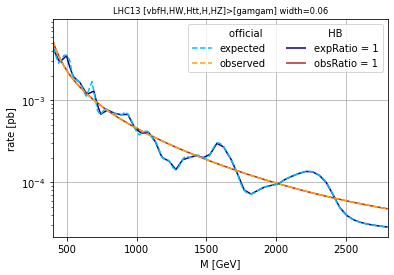

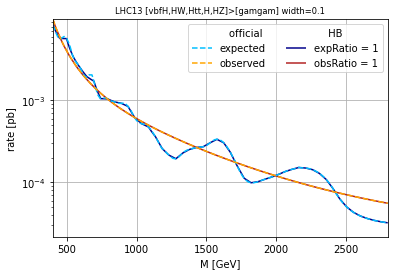

In [2]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1849059/Table%203/1/csv"
)
df = dfs[0].rename(
    columns={
        "Mass [GeV]": "m",
        "Resonance Width [% of mX]": "normWidth",
        "Cross section upper limit at 95% CL [fb]": "obs",
    }
)
df["exp"] = dfs[1]["Cross section upper limit at 95% CL [fb]"]
df.obs *= 1e-3  # fb to pb
df.exp *= 1e-3
df.normWidth *= 1e-1  # this is incorrect in HEPData! it says it's % but it's not (compare the figure)

# turn acceptances from the fits of Aux Tab 2 into points for the linear interpolation
Cx = lambda m: -5.957 - 0.335 * np.exp(-3.07e-3 * m) + 6.74 * np.exp(-0.00344e-3 * m)
AxggF = lambda m: -5.968 - 0.23 * np.exp(-2.999e-3 * m) + 6.730 * np.exp(0.001e-3 * m)
AxttH = lambda m: -6.046 - 0.204 * np.exp(-1.883e-3 * m) + 6.647 * np.exp(0.0047e-3 * m)
Axvbf = lambda m: -5.951 - 0.368 * np.exp(-3.220e-3 * m) + 6.746 * np.exp(3e-9 * m)
AxVH = lambda m: -6.021 - 0.323 * np.exp(-3.812e-3 * m) + 6.675 * np.exp(2.1e-6 * m)

acceptances = {
    "H": lambda m: Cx(m) * AxggF(m),
    "Htt": lambda m: Cx(m) * AxttH(m),
    "vbfH": lambda m: Cx(m) * Axvbf(m),
    "HZ": lambda m: Cx(m) * AxVH(m),
}
acceptances["HW"] = acceptances["HZ"]

prods = ["H", "Htt", "vbfH", "HZ", "HW"]

masses = np.linspace(400, 3000, 100)
fits = {p: pwlf.PiecewiseLinFit(masses, acceptances[p](masses)) for p in prods}
for p, fit in fits.items():
    fit.fit(5)

plt.figure()
for p in prods:
    line = plt.plot(masses, acceptances[p](masses), "o", alpha=0.1)
    plt.plot(masses, fits[p].predict(masses), "-", c=line[0].get_color(), label=p)
plt.legend()
plt.show()


limitFile = implementChannelWidthLimit(
    "2102.13405",
    {"channels": [[p, "gamgam"] for p in prods]},
    "https://doi.org/10.17182/hepdata.100161.v1/t3",
    df,
    massResolution=resolution.gamgam["default"],
    acceptances=[
        {
            "massDepAcceptance": fits[p].predict(fits[p].fit_breaks),
            "massGrid": fits[p].fit_breaks,
        }
        for p in prods
    ],
    idSuffix=1,  # 2 is the low mass region NWA limit
)
lim = HB.Limit(limitFile)


def accountForEfficiencies(h, rate):
    for p in prods:
        h.setChannelRate(
            lim.collider(),
            p,
            "gamgam",
            h.channelRate(lim.collider(), p, "gamgam") / fits[p].predict(h.mass()),
        )


validateChannelWidthLimit(
    lim, setAdditionalRates=accountForEfficiencies, widthsToPlot=[0, 2e-2, 6e-2, 10e-2]
)


## `H>gamgam` low-mass NWA fiducial cxn limit with efficiencies [2102.13405](https://arxiv.org/abs/2102.13405)

Only implement the NWA limit up to 400 GeV where the finite width limit starts.

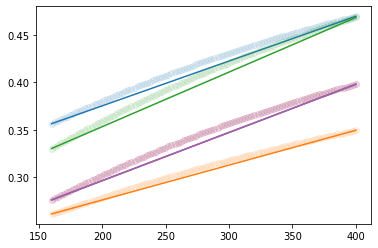

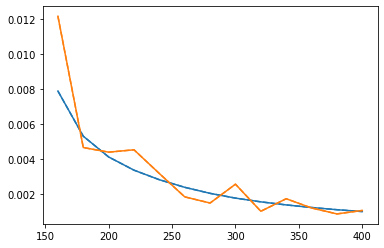

Looks good. Saving this to comb_medMass_LHC13_ATLAS_139.json


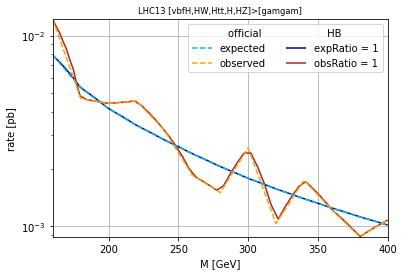

In [3]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1849059/Table%201/1/csv"
)
df = dfs[0].rename(
    columns={"Mass [GeV]": "m", "Cross section upper limit at 95% CL [fb]": "obs"}
)
df["exp"] = dfs[1]["Cross section upper limit at 95% CL [fb]"]
df.obs *= 1e-3
df.exp *= 1e-3
df = df.loc[df.m <= 400].reset_index(drop=True)


# the acceptances are linear to a decent (and conservative) approximation across this small mass range
Cx = lambda m: -5.957 - 0.335 * np.exp(-3.07e-3 * m) + 6.74 * np.exp(-0.00344e-3 * m)
AxggF = lambda m: -5.968 - 0.23 * np.exp(-2.999e-3 * m) + 6.730 * np.exp(0.001e-3 * m)
AxttH = lambda m: -6.046 - 0.204 * np.exp(-1.883e-3 * m) + 6.647 * np.exp(0.0047e-3 * m)
Axvbf = lambda m: -5.951 - 0.368 * np.exp(-3.220e-3 * m) + 6.746 * np.exp(3e-9 * m)
AxVH = lambda m: -6.021 - 0.323 * np.exp(-3.812e-3 * m) + 6.675 * np.exp(2.1e-6 * m)

acceptances = {
    "H": lambda m: Cx(m) * AxggF(m),
    "Htt": lambda m: Cx(m) * AxttH(m),
    "vbfH": lambda m: Cx(m) * Axvbf(m),
    "HZ": lambda m: Cx(m) * AxVH(m),
}
acceptances["HW"] = acceptances["HZ"]

edges = np.array([160, 400])
masses = np.linspace(*edges, 100)

prods = ["H", "Htt", "vbfH", "HZ", "HW"]

plt.figure()
for p in prods:
    line = plt.plot(masses, acceptances[p](masses), "o", alpha=0.1)
    plt.plot(edges, acceptances[p](edges), "-", c=line[0].get_color(), label=p)
plt.show()


limitFile = implementChannelLimit(
    "2102.13405",
    {"channels": [[p, "gamgam"] for p in prods]},
    "https://doi.org/10.17182/hepdata.100161.v1/t3",
    df,
    massResolution=resolution.gamgam["default"],
    acceptances=[
        {
            "massDepAcceptance": acceptances[p](edges),
            "massGrid": edges,
        }
        for p in prods
    ],
    idSuffix=2,
    prefix="comb_medMass",
)
lim = HB.Limit(limitFile)


fits = {p: interp1d(edges, acceptances[p](edges), kind="linear") for p in prods}


def accountForEfficiencies(h, rate):
    for p in prods:
        h.setChannelRate(
            lim.collider(),
            p,
            "gamgam",
            h.channelRate(lim.collider(), p, "gamgam") / fits[p](h.mass()),
        )


fig, ax = validateChannelLimit(lim, setAdditionalRates=accountForEfficiencies)


# ATLAS 8TeV LHC

## `H>gamgam` fiducial cxn limit with efficiencies [1407.6583](https://arxiv.org/abs/1407.6583)

The hepdata entry only has the observed limit. So we combine that with the digitized expected limit from HB5. 

The efficiencies are read from Aux Fig 4. Only low-mass Htt and vbfH are treated with distinct acceptances from the rest. 

The analysis treats the SM Higgs as part of the background, which means that we can't use it around 125 GeV, therefore we just set the expected limit to a huge value there.

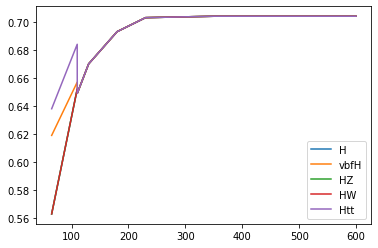

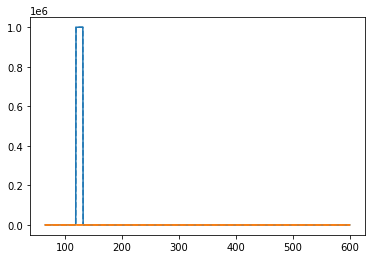

Looks good. Saving this to comb_LHC8_ATLAS_20.json


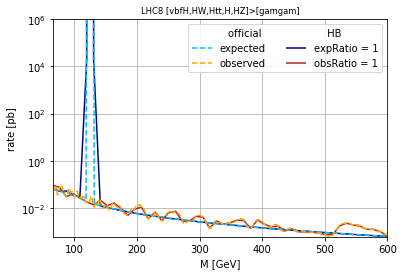

In [4]:
dfOld = fromHB5Table1("6583_Atlas_H-gaga_20.3fb-1", "ATLAS")
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1307756/Table%201/1/csv", skip=1
)
df = dfs[0].rename(columns={"M_X [GEV]": "m", "SIG(fiducial) LIMIT [FB]": "obs"})
# there are two datapoints for 110 GeV, where the technique changes
df.loc[df.m == 110, "m"] = [109.9, 110]

df["exp"] = interp1d(dfOld.m, dfOld.exp, kind="linear")(df.m)
df.obs *= 1e-3
df.exp *= 1e-3


df.loc[(df.m >= 119) & (df.m <= 131), "exp"] = 1e6

highMAcc = [0.649, 0.67, 0.693, 0.703, 0.704, 0.704]
accGrid = [65.0, 109.9, 110.0, 130.0, 180.0, 230.0, 350.0, 600.0]
acceptances = {
    "H": {"massDepAcceptance": [0.563, 0.652] + highMAcc, "massGrid": accGrid},
    "Htt": {"massDepAcceptance": [0.638, 0.684] + highMAcc, "massGrid": accGrid},
    "vbfH": {"massDepAcceptance": [0.619, 0.657] + highMAcc, "massGrid": accGrid},
}
acceptances["HZ"] = acceptances["H"]
acceptances["HW"] = acceptances["H"]

prods = ["H", "vbfH", "HZ", "HW", "Htt"]

plt.figure()
for p in prods:
    plt.plot(acceptances[p]["massGrid"], acceptances[p]["massDepAcceptance"], label=p)
plt.legend()
plt.show()


limitFile = implementChannelLimit(
    "1407.6583",
    {"channels": [[p, "gamgam"] for p in prods]},
    "Fig. 4",
    df,
    massResolution=resolution.gamgam["default"],
    acceptances=[acceptances[p] for p in prods],
)
lim = HB.Limit(limitFile)

fits = {
    p: interp1d(
        acceptances[p]["massGrid"], acceptances[p]["massDepAcceptance"], kind="linear"
    )
    for p in prods
}


def accountForEfficiencies(h, rate):
    for p in prods:
        chan = [lim.collider(), p, "gamgam"]
        h.setChannelRate(*chan, h.channelRate(*chan) / fits[p](h.mass()))


fig, ax = validateChannelLimit(lim, setAdditionalRates=accountForEfficiencies)
